In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\anaconda3\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/GitHub/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Regression.latent_variable_regressors import GBoostRegression, RFRegression, LinearRegressionModel, ElasticLinear

In [4]:
Results_RF = []
Results_XGB = []
Results_LM=[]
Results_ElasticNet=[]
shap_values_list_xgb = None
shap_values_list_ElasticNet = None
#shap_values_list_LM = None
#shap_values_list_RF = None

def store_and_print_results(model_name, results_dict, results_list, i):
    """Store results in the given list and print them."""
    metrics = (results_dict['mse'], results_dict['r2'], results_dict['mae'], results_dict['train_mse'], results_dict['train_r2'])
    results_list.append(metrics)
    
    print(f"Iteration {i+1} {model_name}: MSE: {metrics[0]}, R^2: {metrics[1]}, MAE: {metrics[2]}, TRAIN_MSE: {metrics[3]}, TRAIN_R^2: {metrics[4]}")


In [5]:
montecarloiter=5


for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")

    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    try:
        processorclass.process_CFA()
    except Exception as e:
        print(f"Error during process_CFA for iteration n.{i+1}: {e}")
        continue    

    X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable='WorkEngagement')

    ## XGBRegressor
    #Xgboost=GBoostRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    #Xgboost.train(verbosity=0,n_iter=60,cv=5)
    #store_and_print_results('XGB',Xgboost.get_results(),Results_XGB,i)
#
    #if shap_values_list_xgb is None:
    #    shap_values_list_xgb = Xgboost.get_shap_values()
    #else:
    #    shap_values_list_xgb += Xgboost.get_shap_values()
#
    ## RandomForest
    #RFRegre=RFRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    #RFRegre.median_imputation()
    #RFRegre.train(verbosity=0,n_iter=25,computeshap=False)
    #store_and_print_results('RandomForest',RFRegre.get_results(),Results_RF,i)

    # Linear Regression
    LMreg= LinearRegressionModel(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    LMreg.median_imputation()
    LMreg.train(computeshap=False)
    store_and_print_results('LinearRegression',LMreg.get_results(),Results_LM,i)

    # ElasticLinear
    Elasticregr = ElasticLinear(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    Elasticregr.median_imputation(standardscaling=True)
    Elasticregr.train(computeshap=True,verbosity=0,n_iter=60)
    store_and_print_results('ElasticNet',Elasticregr.get_results(),Results_ElasticNet,i)

    if shap_values_list_ElasticNet is None:
        shap_values_list_ElasticNet = Elasticregr.get_shap_values()
    else:
        shap_values_list_ElasticNet += Elasticregr.get_shap_values()

    print(("-------------------------------------------------"))


#shap_values_list_xgb /= montecarloiter
shap_values_list_ElasticNet /= montecarloiter
# shap_values_list_LM /= montecarloiter
# shap_values_list_RF /= montecarloiter

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the Linear Regression training
Iteration 1 LinearRegression: MSE: 0.07317340880825653, R^2: 0.8437209035730684, MAE: 0.2138132992376681, TRAIN_MSE: 0.07957875717690176, TRAIN_R^2: 0.8117449566604985
Iteration 1 ElasticNet: MSE: 0.07470409373798863, R^2: 0.8404517643921988, MAE: 0.21685958383518353, TRAIN_MSE: 0.08065905526274622, TRAIN_R^2: 0.809189355515357
-------------------------------------------------
Starting the iteration n.2
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the Linear Regression training
Iteration 2 LinearRegression: MSE: 0.05344953912505126, R^2: 0.864170547827025, MAE: 0.18229333767678718, TRAIN_MSE: 0.09212834147821729, TRAIN_R^2: 0.7984687777693218
Iteration 2 ElasticNet: MSE: 0.05032744869412003, R^2: 0.8721046074991899, MAE: 

In [ ]:
import numpy as np

def compute_95_CI(results):
    std_error = np.std(results) / np.sqrt(len(results))
    ci_upper = np.mean(results) + 1.96 * std_error
    ci_lower = np.mean(results) - 1.96 * std_error
    return ci_lower, ci_upper

def print_avg_metrics(Results, model_name):
    mse_avg = np.mean([res[0] for res in Results])
    r2_avg = np.mean([res[1] for res in Results])
    mae_avg = np.mean([res[2] for res in Results])
    train_mse_avg = np.mean([res[3] for res in Results])
    train_r2_avg = np.mean([res[4] for res in Results])
    # Calculate CIs
    mse_ci = compute_95_CI([res[0] for res in Results])
    r2_ci = compute_95_CI([res[1] for res in Results])
    mae_ci = compute_95_CI([res[2] for res in Results])
    train_mse_ci = compute_95_CI([res[3] for res in Results])
    train_r2_ci = compute_95_CI([res[4] for res in Results])
    
    print(f"Model: {model_name}")
    print(f"Average MSE over {montecarloiter} iterations: {mse_avg:.3f} (95% CI: {mse_ci[0]:.3f} - {mse_ci[1]:.3f})")
    print(f"Average MAE over {montecarloiter} iterations: {mae_avg:.3f} (95% CI: {mae_ci[0]:.3f} - {mae_ci[1]:.3f})")
    print(f"Average R^2 over {montecarloiter} iterations: {r2_avg:.3f} (95% CI: {r2_ci[0]:.3f} - {r2_ci[1]:.3f})")
    print(f"Average Training MSE over {montecarloiter} iterations: {train_mse_avg:.3f} (95% CI: {train_mse_ci[0]:.3f} - {train_mse_ci[1]:.3f})")
    print(f"Average Training R^2 over {montecarloiter} iterations: {train_r2_avg:.3f} (95% CI: {train_r2_ci[0]:.3f} - {train_r2_ci[1]:.3f})")
    print("-------------------------------------------------")


# Print the metrics for each model
#print_avg_metrics(Results_XGB, "XGBoost")
#print_avg_metrics(Results_RF, "Random Forest")
print_avg_metrics(Results_LM, "Linear Model")
print_avg_metrics(Results_ElasticNet, "Elastic Net")




Model: Linear Model
Average MSE over 5 iterations: 0.054 (95% CI: 0.054 - 0.054)
Average MAE over 5 iterations: 0.183 (95% CI: 0.183 - 0.183)
Average R^2 over 5 iterations: 0.871 (95% CI: 0.871 - 0.871)
Average Training MSE over 5 iterations: 0.098 (95% CI: 0.098 - 0.098)
Average Training R^2 over 5 iterations: 0.782 (95% CI: 0.782 - 0.782)
-------------------------------------------------
Model: Elastic Net
Average MSE over 5 iterations: 0.055 (95% CI: 0.055 - 0.055)
Average MAE over 5 iterations: 0.186 (95% CI: 0.186 - 0.186)
Average R^2 over 5 iterations: 0.870 (95% CI: 0.870 - 0.870)
Average Training MSE over 5 iterations: 0.100 (95% CI: 0.100 - 0.100)
Average Training R^2 over 5 iterations: 0.779 (95% CI: 0.779 - 0.779)
-------------------------------------------------


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


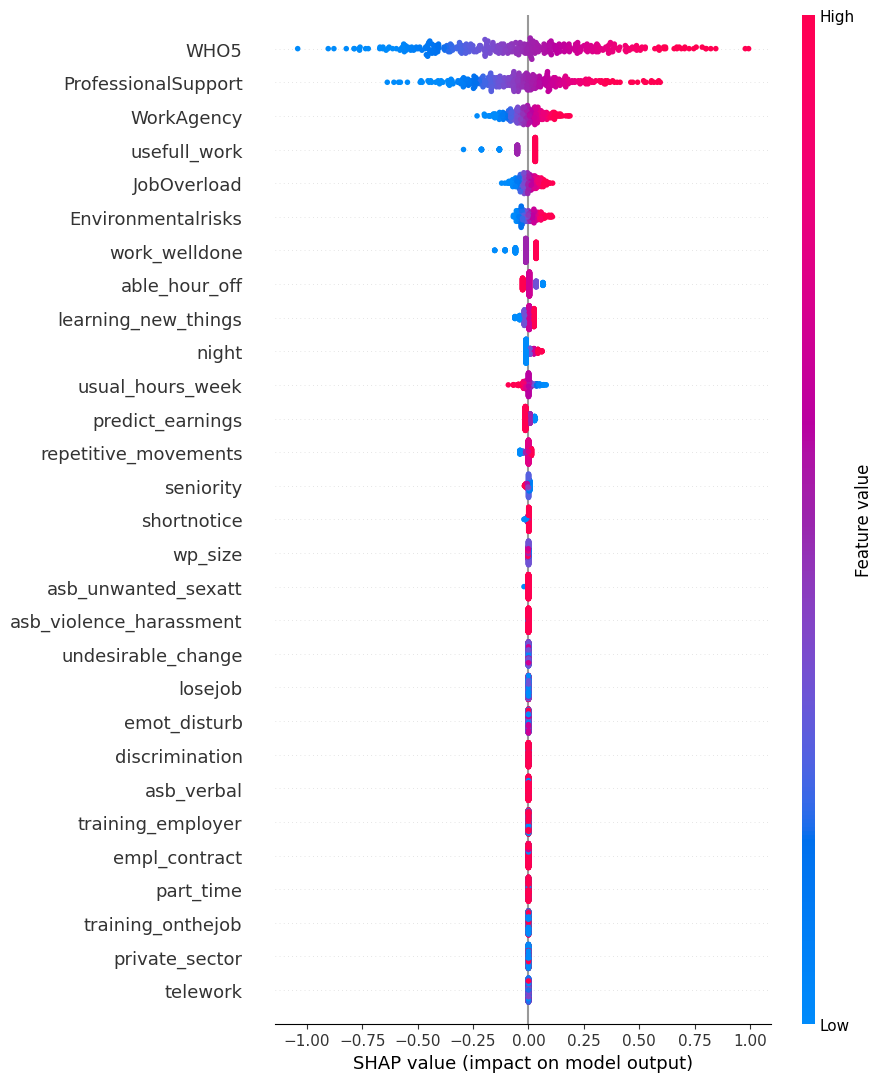

In [ ]:
shap.plots.beeswarm(shap_values_list_ElasticNet, max_display=30)

In [ ]:
#shap.waterfall_plot(shap_values_list_ElasticNet[2])


In [ ]:
shap.plots.heatmap(shap_values_list_xgb, instance_order=shap_values_list_xgb.sum(1))

AttributeError: 'NoneType' object has no attribute 'sum'

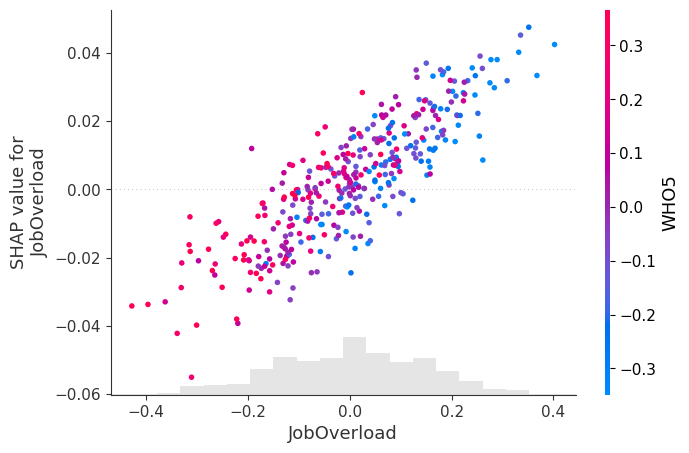

In [ ]:
shap.plots.scatter(shap_values_list_xgb[:, "JobOverload"],color=shap_values_list_xgb[:, "WHO5"])
#color=plt.get_cmap("cool")
#color=shap_values[:,"Workclass"])
